In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pandapower as pp
import pandapower.plotting as plot
import scipy.stats as stats
import seaborn as sns
import simbench as sb
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.neural_network
import sklearn.svm
import time
import torch
import torch.nn as nn
import tspiral
from datetime import datetime
from masterthesis_helper_functions import evaluate_regression, plot_actual_vs_predicted_time_series
from networkx.drawing.nx_pydot import graphviz_layout
from pandapower.timeseries.run_time_series import run_timeseries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBRegressor


from darts import TimeSeries
from darts.models import ExponentialSmoothing, AutoARIMA, NBEATSModel
from darts.metrics import mae
from darts.models import LinearRegressionModel
from darts.models import RegressionModel
from darts.models import XGBModel
from darts.models import RandomForest

c:\Programming\hslu_masterthesis\venv\Lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
def evaluate_regression(y_true, y_pred, X):
    """
    Evaluates the performance of a regression model using various metrics.
    
    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values from the model
    - X: array-like, feature dataset used for prediction
    
    Returns:
    A dictionary containing the computed metrics.
    """
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    n = X.shape[0]  # Number of samples
    p = X.shape[1]  # Number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    mape = np.nanmean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100
    
    
    # Return results as a dictionary
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'MEDAE': medae,
        'RMSE': rmse,
        'R^2': r2,
        'Adjusted R^2': adjusted_r2,
        'MAPE': mape
    }
    
    return metrics

In [3]:
# Path to the directory
dir_path = 'rural1_s1'

# List all files in the directory
files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

# Dictionary to hold your dataframes
dataframes = {}

# Loop through the files and read each into a pandas DataFrame
for file in files:
    # Create a DataFrame name by stripping the file extension
    df_name = file.split('.')[0]
    
    # Construct file path
    file_path = os.path.join(dir_path, file)
    
    # Read the file into a DataFrame
    df = None  # Initialize to None before reading
    if file.endswith('.csv'):  # Check if the file is a CSV
        df = pd.read_csv(file_path)
    elif file.endswith('.xlsx'):  # Add more conditions for other file types
        df = pd.read_excel(file_path)
    
    # If a DataFrame was successfully created, set the datetime column as index
    if df is not None and 'datetime' in df.columns:
        df.set_index('datetime', inplace=True)
        dataframes[df_name] = df

# Create a variable for each dataframe
for name, df in dataframes.items():
    globals()[name] = df

# One hot encoding the column 'is_weekend' in every dataframe
for name, df in dataframes.items():
    if 'is_weekend' in df.columns:
        df = pd.get_dummies(df, columns=['is_weekend_1'], drop_first=True)
        dataframes[name] = df

In [4]:
# What dataframes do we have?
print(dataframes.keys())

dict_keys(['df_15min', 'df_1d', 'df_1h', 'df_6h', 'test_15min', 'test_1d', 'test_1h', 'test_6h', 'train_15min', 'train_1d', 'train_1h', 'train_6h', 'validate_15min', 'validate_1d', 'validate_1h', 'validate_6h'])


In [5]:
# Print head of df_15min
df_15min.head()

,trafo_p_hv_mw,trafo_q_hv_mvar,trafo_p_lv_mw,trafo_q_lv_mvar,trafo_pl_mw,trafo_ql_mvar,trafo_i_hv_ka,trafo_i_lv_ka,trafo_vm_hv_pu,trafo_va_hv_degree,trafo_vm_lv_pu,trafo_va_lv_degree,trafo_loading_percent,load_p_LV1.101 Bus 10,load_p_LV1.101 Bus 8,load_p_LV1.101 Bus 14,load_p_LV1.101 Bus 13,load_p_LV1.101 Bus 9,load_p_LV1.101 Bus 6,load_p_LV1.101 Bus 3,load_p_LV1.101 Bus 1,load_p_LV1.101 Bus 7,load_p_LV1.101 Bus 12,load_p_LV1.101 Bus 11,load_p_LV1.101 Bus 2,load_p_LV1.101 Bus 5,load_q_LV1.101 Bus 10,load_q_LV1.101 Bus 8,load_q_LV1.101 Bus 14,load_q_LV1.101 Bus 13,load_q_LV1.101 Bus 9,load_q_LV1.101 Bus 6,load_q_LV1.101 Bus 3,load_q_LV1.101 Bus 1,load_q_LV1.101 Bus 7,load_q_LV1.101 Bus 12,load_q_LV1.101 Bus 11,load_q_LV1.101 Bus 2,load_q_LV1.101 Bus 5,sgen_p_LV1.101 Bus 7,sgen_p_LV1.101 Bus 11,sgen_p_LV1.101 Bus 8,sgen_p_LV1.101 Bus 13,interval_index,hour_of_day,day_of_week,month_of_year,sin_hour_of_day,sin_day_of_week,sin_month_of_year,is_weekend_1
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-0.138606,0.036278,0.140890,-0.031716,0.002285,0.004562,0.004035,0.202417,1.025,0.0,1.029791,1.933737,87.648978,0.001926,0.000711,0.000721,0.000132,0.001284,0.000433,0.001154,0.004495,0.000963,0.001731,0.000553,0.000577,0.004495,0.000774,0.000287,0.000248,-0.000011,0.000516,0.000149,0.000397,0.001806,0.000387,0.000595,-0.000053,0.000198,0.001806,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0
2016-01-01 00:15:00,-0.130922,0.035803,0.133022,-0.031707,0.002100,0.004096,0.003823,0.191789,1.025,0.0,1.029152,1.835468,83.047229,0.001905,0.000201,0.002083,0.000381,0.001270,0.001250,0.003333,0.004446,0.000953,0.005000,0.000132,0.001667,0.004446,0.000821,0.000009,0.001161,0.000168,0.000547,0.000697,0.001858,0.001916,0.000411,0.002786,0.000048,0.000929,0.001916,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0
2016-01-01 00:30:00,-0.126639,0.035554,0.128641,-0.031707,0.002002,0.003847,0.003704,0.185882,1.025,0.0,1.028794,1.780720,80.489240,0.002505,0.000191,0.002092,0.000336,0.001670,0.001255,0.003347,0.005846,0.001253,0.005021,0.000413,0.001674,0.005846,0.000942,0.000014,0.001199,0.000048,0.000628,0.000720,0.001919,0.002199,0.000471,0.002878,0.000059,0.000959,0.002199,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0
2016-01-01 00:45:00,-0.126705,0.035556,0.128708,-0.031706,0.002003,0.003851,0.003706,0.185972,1.025,0.0,1.028799,1.781552,80.528190,0.002242,0.000196,0.002404,0.000227,0.001495,0.001442,0.003846,0.005232,0.001121,0.005769,0.000256,0.001923,0.005232,0.000937,0.000032,0.001219,0.000008,0.000625,0.000732,0.001951,0.002186,0.000469,0.002927,0.000008,0.000976,0.002186,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0
2016-01-01 01:00:00,-0.126007,0.035517,0.127994,-0.031706,0.001988,0.003811,0.003687,0.185010,1.025,0.0,1.028741,1.772634,80.111883,0.002463,0.000228,0.002274,0.000269,0.001642,0.001364,0.003638,0.005747,0.001232,0.005457,0.000216,0.001819,0.005747,0.000831,0.000032,0.001243,0.000020,0.000554,0.000746,0.001989,0.001940,0.000416,0.002983,0.000020,0.000994,0.001940,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.258819,-0.433884,0.0,0.0


In [6]:
def preprocess_data(df, target_col, exclude_columns):
    # Drop the specified columns, if they are in the dataframe
    df = df.drop(columns=[col for col in exclude_columns if col in df.columns], errors='ignore')
    
    # Separate the target variable
    target = df[target_col] if target_col in df.columns else None
    features = df.drop(columns=[target_col], errors='ignore')
    
    return features, target

# Function withs adds a datetime colum to the dataframes. Currently this is the index
def add_datetime_column(df):
    df['datetime'] = df.index
    # Convert datetime to datetime object
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

# Add datetime column to all dataframes
for name, df in dataframes.items():
    dataframes[name] = add_datetime_column(df)

# Preprocess the data
preprocessed_data = {}
exclude_columns = [
    'datetime', 'trafo_q_hv_mvar', 'trafo_p_hv_mw', 'trafo_q_lv_mvar',
    'trafo_pl_mw', 'trafo_ql_mvar', 'trafo_i_hv_ka', 'trafo_i_lv_ka',
    'trafo_vm_hv_pu', 'trafo_va_hv_degree', 'trafo_vm_lv_pu', 'trafo_va_lv_degree',
    'trafo_loading_percent', 'interval_index', 'hour_of_day', 'day_of_week', 'month_of_year'
]
target_column = 'trafo_p_lv_mw'

for name, df in dataframes.items():
    features, target = preprocess_data(df, target_column, exclude_columns)
    preprocessed_data[name] = {'features': features, 'target': target}

In [7]:
TARGET = 'trafo_p_lv_mw'
TARGET

# Features list (columns names from features_15min_train)
features_15min_train = preprocessed_data['train_15min']['features']
feature_columns = list(features_15min_train.columns)

In [40]:
if not isinstance(df_15min.index, pd.DatetimeIndex):
    df_1d['datetime'] = pd.to_datetime(df_15min['datetime'])
    df_1d.set_index('datetime', inplace=True)

In [22]:
df_15min.head()

,trafo_p_hv_mw,trafo_q_hv_mvar,trafo_p_lv_mw,trafo_q_lv_mvar,trafo_pl_mw,trafo_ql_mvar,trafo_i_hv_ka,trafo_i_lv_ka,trafo_vm_hv_pu,trafo_va_hv_degree,trafo_vm_lv_pu,trafo_va_lv_degree,trafo_loading_percent,load_p_LV1.101 Bus 10,load_p_LV1.101 Bus 8,load_p_LV1.101 Bus 14,load_p_LV1.101 Bus 13,load_p_LV1.101 Bus 9,load_p_LV1.101 Bus 6,load_p_LV1.101 Bus 3,load_p_LV1.101 Bus 1,load_p_LV1.101 Bus 7,load_p_LV1.101 Bus 12,load_p_LV1.101 Bus 11,load_p_LV1.101 Bus 2,load_p_LV1.101 Bus 5,load_q_LV1.101 Bus 10,load_q_LV1.101 Bus 8,load_q_LV1.101 Bus 14,load_q_LV1.101 Bus 13,load_q_LV1.101 Bus 9,load_q_LV1.101 Bus 6,load_q_LV1.101 Bus 3,load_q_LV1.101 Bus 1,load_q_LV1.101 Bus 7,load_q_LV1.101 Bus 12,load_q_LV1.101 Bus 11,load_q_LV1.101 Bus 2,load_q_LV1.101 Bus 5,sgen_p_LV1.101 Bus 7,sgen_p_LV1.101 Bus 11,sgen_p_LV1.101 Bus 8,sgen_p_LV1.101 Bus 13,interval_index,hour_of_day,day_of_week,month_of_year,sin_hour_of_day,sin_day_of_week,sin_month_of_year,is_weekend_1,datetime
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-0.138606,0.036278,0.140890,-0.031716,0.002285,0.004562,0.004035,0.202417,1.025,0.0,1.029791,1.933737,87.648978,0.001926,0.000711,0.000721,0.000132,0.001284,0.000433,0.001154,0.004495,0.000963,0.001731,0.000553,0.000577,0.004495,0.000774,0.000287,0.000248,-0.000011,0.000516,0.000149,0.000397,0.001806,0.000387,0.000595,-0.000053,0.000198,0.001806,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0,2016-01-01 00:00:00
2016-01-01 00:15:00,-0.130922,0.035803,0.133022,-0.031707,0.002100,0.004096,0.003823,0.191789,1.025,0.0,1.029152,1.835468,83.047229,0.001905,0.000201,0.002083,0.000381,0.001270,0.001250,0.003333,0.004446,0.000953,0.005000,0.000132,0.001667,0.004446,0.000821,0.000009,0.001161,0.000168,0.000547,0.000697,0.001858,0.001916,0.000411,0.002786,0.000048,0.000929,0.001916,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0,2016-01-01 00:15:00
2016-01-01 00:30:00,-0.126639,0.035554,0.128641,-0.031707,0.002002,0.003847,0.003704,0.185882,1.025,0.0,1.028794,1.780720,80.489240,0.002505,0.000191,0.002092,0.000336,0.001670,0.001255,0.003347,0.005846,0.001253,0.005021,0.000413,0.001674,0.005846,0.000942,0.000014,0.001199,0.000048,0.000628,0.000720,0.001919,0.002199,0.000471,0.002878,0.000059,0.000959,0.002199,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0,2016-01-01 00:30:00
2016-01-01 00:45:00,-0.126705,0.035556,0.128708,-0.031706,0.002003,0.003851,0.003706,0.185972,1.025,0.0,1.028799,1.781552,80.528190,0.002242,0.000196,0.002404,0.000227,0.001495,0.001442,0.003846,0.005232,0.001121,0.005769,0.000256,0.001923,0.005232,0.000937,0.000032,0.001219,0.000008,0.000625,0.000732,0.001951,0.002186,0.000469,0.002927,0.000008,0.000976,0.002186,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0,2016-01-01 00:45:00
2016-01-01 01:00:00,-0.126007,0.035517,0.127994,-0.031706,0.001988,0.003811,0.003687,0.185010,1.025,0.0,1.028741,1.772634,80.111883,0.002463,0.000228,0.002274,0.000269,0.001642,0.001364,0.003638,0.005747,0.001232,0.005457,0.000216,0.001819,0.005747,0.000831,0.000032,0.001243,0.000020,0.000554,0.000746,0.001989,0.001940,0.000416,0.002983,0.000020,0.000994,0.001940,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.258819,-0.433884,0.0,0.0,2016-01-01 01:00:00


In [41]:
# Calculate Split date
split_date70 = int(len(df_15min.index)*0.7)
# max Date (length of the index)
max_date = len(df_15min.index)
split_date = max_date - split_date70

In [42]:
df_15min.head()

,trafo_p_hv_mw,trafo_q_hv_mvar,trafo_p_lv_mw,trafo_q_lv_mvar,trafo_pl_mw,trafo_ql_mvar,trafo_i_hv_ka,trafo_i_lv_ka,trafo_vm_hv_pu,trafo_va_hv_degree,trafo_vm_lv_pu,trafo_va_lv_degree,trafo_loading_percent,load_p_LV1.101 Bus 10,load_p_LV1.101 Bus 8,load_p_LV1.101 Bus 14,load_p_LV1.101 Bus 13,load_p_LV1.101 Bus 9,load_p_LV1.101 Bus 6,load_p_LV1.101 Bus 3,load_p_LV1.101 Bus 1,load_p_LV1.101 Bus 7,load_p_LV1.101 Bus 12,load_p_LV1.101 Bus 11,load_p_LV1.101 Bus 2,load_p_LV1.101 Bus 5,load_q_LV1.101 Bus 10,load_q_LV1.101 Bus 8,load_q_LV1.101 Bus 14,load_q_LV1.101 Bus 13,load_q_LV1.101 Bus 9,load_q_LV1.101 Bus 6,load_q_LV1.101 Bus 3,load_q_LV1.101 Bus 1,load_q_LV1.101 Bus 7,load_q_LV1.101 Bus 12,load_q_LV1.101 Bus 11,load_q_LV1.101 Bus 2,load_q_LV1.101 Bus 5,sgen_p_LV1.101 Bus 7,sgen_p_LV1.101 Bus 11,sgen_p_LV1.101 Bus 8,sgen_p_LV1.101 Bus 13,interval_index,hour_of_day,day_of_week,month_of_year,sin_hour_of_day,sin_day_of_week,sin_month_of_year,is_weekend_1
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-0.138606,0.036278,0.140890,-0.031716,0.002285,0.004562,0.004035,0.202417,1.025,0.0,1.029791,1.933737,87.648978,0.001926,0.000711,0.000721,0.000132,0.001284,0.000433,0.001154,0.004495,0.000963,0.001731,0.000553,0.000577,0.004495,0.000774,0.000287,0.000248,-0.000011,0.000516,0.000149,0.000397,0.001806,0.000387,0.000595,-0.000053,0.000198,0.001806,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0
2016-01-01 00:15:00,-0.130922,0.035803,0.133022,-0.031707,0.002100,0.004096,0.003823,0.191789,1.025,0.0,1.029152,1.835468,83.047229,0.001905,0.000201,0.002083,0.000381,0.001270,0.001250,0.003333,0.004446,0.000953,0.005000,0.000132,0.001667,0.004446,0.000821,0.000009,0.001161,0.000168,0.000547,0.000697,0.001858,0.001916,0.000411,0.002786,0.000048,0.000929,0.001916,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0
2016-01-01 00:30:00,-0.126639,0.035554,0.128641,-0.031707,0.002002,0.003847,0.003704,0.185882,1.025,0.0,1.028794,1.780720,80.489240,0.002505,0.000191,0.002092,0.000336,0.001670,0.001255,0.003347,0.005846,0.001253,0.005021,0.000413,0.001674,0.005846,0.000942,0.000014,0.001199,0.000048,0.000628,0.000720,0.001919,0.002199,0.000471,0.002878,0.000059,0.000959,0.002199,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0
2016-01-01 00:45:00,-0.126705,0.035556,0.128708,-0.031706,0.002003,0.003851,0.003706,0.185972,1.025,0.0,1.028799,1.781552,80.528190,0.002242,0.000196,0.002404,0.000227,0.001495,0.001442,0.003846,0.005232,0.001121,0.005769,0.000256,0.001923,0.005232,0.000937,0.000032,0.001219,0.000008,0.000625,0.000732,0.001951,0.002186,0.000469,0.002927,0.000008,0.000976,0.002186,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,-0.433884,0.0,0.0
2016-01-01 01:00:00,-0.126007,0.035517,0.127994,-0.031706,0.001988,0.003811,0.003687,0.185010,1.025,0.0,1.028741,1.772634,80.111883,0.002463,0.000228,0.002274,0.000269,0.001642,0.001364,0.003638,0.005747,0.001232,0.005457,0.000216,0.001819,0.005747,0.000831,0.000032,0.001243,0.000020,0.000554,0.000746,0.001989,0.001940,0.000416,0.002983,0.000020,0.000994,0.001940,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.258819,-0.433884,0.0,0.0


In [49]:
# Convert pandas DataFrame to TimeSeries
y = TimeSeries.from_series(df_15min[TARGET])
features = feature_columns
feature_cov = TimeSeries.from_dataframe(df_15min[feature_columns])

# Hold out 30% of the data for testing
y_train = y[:-split_date]

<Axes: xlabel='datetime'>

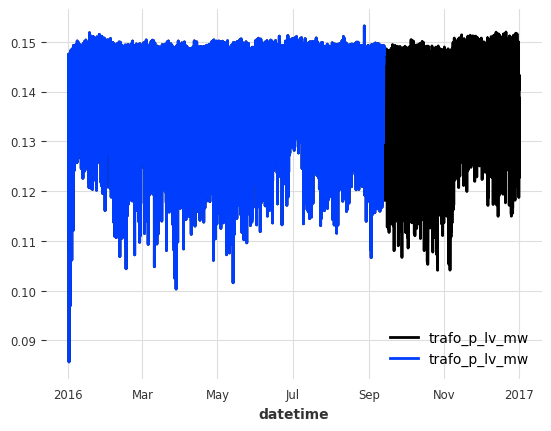

In [50]:
y.plot()  
y_train.plot()

In [51]:
# Specify and train the model
model = RegressionModel(
    lags = [-2],
    lags_future_covariates = [-1],
    model = LinearRegression()
    )

model.fit(series=y_train, future_covariates=feature_cov)

RegressionModel(lags=[-2], lags_past_covariates=None, lags_future_covariates=[-1], output_chunk_length=1, output_chunk_shift=0, add_encoders=None, model=LinearRegression(), multi_models=True, use_static_covariates=True)

In [52]:
y_pred = model.predict(n=split_date, 
                       series=y_train,
                       future_covariates=feature_cov
                       )

<bound method TimeSeries.pd_dataframe of <TimeSeries (DataArray) (datetime: 110, component: 1, sample: 1)> Size: 880B
array([[[0.13748443]],

       [[0.13606128]],

       [[0.13654676]],

       [[0.13377524]],

       [[0.1327311 ]],

       [[0.13346218]],

       [[0.13687359]],

       [[0.13267972]],

       [[0.13283728]],

       [[0.13455948]],

...

       [[0.14120204]],

       [[0.13835185]],

       [[0.1379759 ]],

       [[0.13440223]],

       [[0.13574749]],

       [[0.13997419]],

       [[0.13960776]],

       [[0.13954254]],

       [[0.13838239]],

       [[0.13670259]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 880B 2016-09-13 ... 2016-12-31
  * component  (component) object 8B 'trafo_p_lv_mw'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None>

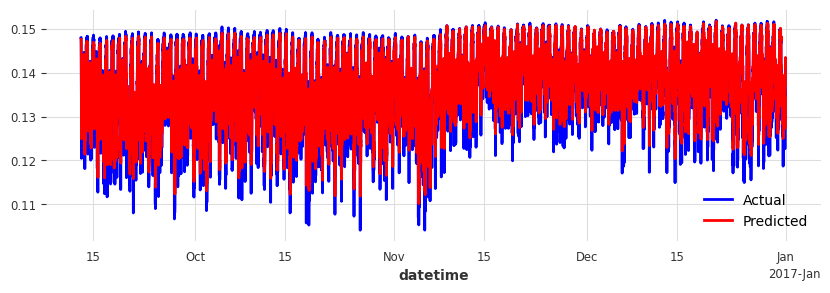

In [53]:
import matplotlib.pyplot as plt

# create a new figure with size 7x3
plt.figure(figsize=(10, 3))

# plot the data
y[-split_date:].plot(label='Actual', color='blue')
y_pred.plot(label='Predicted', color='red')
# Save the plot as svg
plt.savefig('rural1_s1/linear_regression_1d.svg')

In [54]:
# Evaluate the model
# Convert Darts TimeSeries to numpy arrays
y_true = y[-split_date:].values().flatten()  # True values from the original series for the test period
y_pred_array = y_pred.values().flatten()  # Predicted values as a numpy array

# Assuming your feature_cov is the feature set used, but note for regression analysis, 
# this should technically be the number of features used in the model including lags.
# Here we're simplifying by considering just the number of distinct features before lags.
X_used_for_prediction = df_15min[features][-split_date:].values  # Features corresponding to the test period

# Evaluate the model
evaluation_metrics = evaluate_regression(y_true, y_pred_array, X_used_for_prediction)
for metric, value in evaluation_metrics.items():
    print(f'{metric}: {value:.4f}')

MAE: 0.0026
MSE: 0.0000
MEDAE: 0.0017
RMSE: 0.0038
R^2: 0.8146
Adjusted R^2: 0.8140
MAPE: 0.2566


In [16]:
def process_and_evaluate_dataframe(df, target_col, feature_columns, df_name, split_ratio=0.7):
    print(f"Processing dataframe: {df_name}")
    print(f"Number of rows: {len(df)}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Target variable: {target_col}")
    print()

    # Ensure the DataFrame has a valid index
    if not isinstance(df.index, (pd.DatetimeIndex, pd.RangeIndex)):
        df = df.reset_index(drop=True)

    # Convert pandas DataFrame to TimeSeries
    y = TimeSeries.from_series(df[target_col])
    feature_cov = TimeSeries.from_dataframe(df[feature_columns])

    # Calculate Split date
    split_date70 = int(len(y) * split_ratio)
    split_date = len(y) - split_date70

    # Hold out the last portion of the data for testing
    y_train = y[:-split_date]

    # Specify and train the model
    model = RegressionModel(
        lags=[-2],
        lags_future_covariates=[-1],
        model=LinearRegression()
    )

    model.fit(series=y_train, future_covariates=feature_cov)

    y_pred = model.predict(n=split_date,
                           series=y_train,
                           future_covariates=feature_cov)

    # Evaluate the model
    y_true = y[-split_date:].values().flatten()
    y_pred_array = y_pred.values().flatten()
    X_used_for_prediction = df[feature_columns][-split_date:].values

    evaluation_metrics = evaluate_regression(y_true, y_pred_array, X_used_for_prediction)

    print(f"Evaluation metrics for {df_name}:")
    print("=" * 40)
    for metric, value in evaluation_metrics.items():
        print(f'{metric}: {value:.4f}')
    print()

    return evaluation_metrics

In [17]:
# Process and evaluate all dataframes
evaluation_results = {}
for name, data in preprocessed_data.items():
    df = dataframes[name]
    features = data['features']
    target = data['target']
    
    evaluation_results[name] = process_and_evaluate_dataframe(df, TARGET, features.columns, name)

# Print the evaluation results
for name, metrics in evaluation_results.items():
    print(f"Evaluation metrics for {name}:")
    print(metrics)
    print()

Processing dataframe: df_15min
Number of rows: 35136
Number of features: 34
Target variable: trafo_p_lv_mw

Evaluation metrics for df_15min:
MAE: 0.0026
MSE: 0.0000
MEDAE: 0.0017
RMSE: 0.0038
R^2: 0.8146
Adjusted R^2: 0.8140
MAPE: 0.2566

Processing dataframe: df_1d
Number of rows: 366
Number of features: 34
Target variable: trafo_p_lv_mw

Evaluation metrics for df_1d:
MAE: 0.0017
MSE: 0.0000
MEDAE: 0.0012
RMSE: 0.0022
R^2: 0.4319
Adjusted R^2: 0.1743
MAPE: 0.1692

Processing dataframe: df_1h
Number of rows: 8784
Number of features: 34
Target variable: trafo_p_lv_mw

Evaluation metrics for df_1h:
MAE: 0.0031
MSE: 0.0000
MEDAE: 0.0023
RMSE: 0.0042
R^2: 0.7514
Adjusted R^2: 0.7482
MAPE: 0.3132

Processing dataframe: df_6h
Number of rows: 1464
Number of features: 34
Target variable: trafo_p_lv_mw

Evaluation metrics for df_6h:
MAE: 0.0044
MSE: 0.0000
MEDAE: 0.0036
RMSE: 0.0056
R^2: 0.3382
Adjusted R^2: 0.2826
MAPE: 0.4394

Processing dataframe: test_15min
Number of rows: 5271
Number of fe

In [104]:
print(evaluation_results['df_15min'])
print(evaluation_results['df_1h'])
print(evaluation_results['df_6h'])
print(evaluation_results['df_1d'])

{'MAE': 0.0025664775401020756, 'MSE': 1.4361412982333749e-05, 'MEDAE': 0.0016658126722834954, 'RMSE': 0.0037896454956016334, 'R^2': 0.8146340277254207, 'Adjusted R^2': 0.8140341378475094, 'MAPE': 0.25664775401020756}
{'MAE': 0.003132208690779547, 'MSE': 1.7395785702689578e-05, 'MEDAE': 0.002279957195116575, 'RMSE': 0.0041708255421066915, 'R^2': 0.7514398406480411, 'Adjusted R^2': 0.7481906882382117, 'MAPE': 0.3132208690779547}
{'MAE': 0.004394065138587896, 'MSE': 3.0853679998249485e-05, 'MEDAE': 0.0036351914912452765, 'RMSE': 0.005554608896965608, 'R^2': 0.33818508997314745, 'Adjusted R^2': 0.2826253197486709, 'MAPE': 0.43940651385878965}
{'MAE': 0.0016916195197835657, 'MSE': 4.86929838981279e-06, 'MEDAE': 0.0012202238892801004, 'RMSE': 0.0022066486783837587, 'R^2': 0.4318547069077371, 'Adjusted R^2': 0.17429550737257793, 'MAPE': 0.16916195197835657}


# Random Forest (Attention takes 9.4h to run!)

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def process_and_evaluate_dataframe(df, target_col, feature_columns, df_name, split_ratio=0.7):
    print(f"Processing dataframe: {df_name}")
    print(f"Number of rows: {len(df)}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Target variable: {target_col}")
    print()

    # Ensure the DataFrame has a valid index
    if not isinstance(df.index, (pd.DatetimeIndex, pd.RangeIndex)):
        df = df.reset_index(drop=True)

    # Convert pandas DataFrame to TimeSeries
    y = TimeSeries.from_series(df[target_col])
    feature_cov = TimeSeries.from_dataframe(df[feature_columns])

    # Calculate Split date
    split_date70 = int(len(y) * split_ratio)
    split_date = len(y) - split_date70

    # Hold out the last portion of the data for testing
    y_train = y[:-split_date]


    model = RandomForest(
        lags=[-2],
        lags_future_covariates=[-1],
        output_chunk_length=6,
        n_estimators=200,
        criterion="absolute_error",)

    model.fit(series=y_train, future_covariates=feature_cov)

    y_pred = model.predict(n=split_date,
                           series=y_train,
                           future_covariates=feature_cov)

    # Evaluate the model
    y_true = y[-split_date:].values().flatten()
    y_pred_array = y_pred.values().flatten()
    X_used_for_prediction = df[feature_columns][-split_date:].values

    evaluation_metrics = evaluate_regression(y_true, y_pred_array, X_used_for_prediction)

    print(f"Evaluation metrics for {df_name}:")
    print("=" * 40)
    for metric, value in evaluation_metrics.items():
        print(f'{metric}: {value:.4f}')
    print()

    return evaluation_metrics

In [96]:
# Process and evaluate all dataframes with Random Forest
evaluation_results_rf = {}
for name, data in preprocessed_data.items():
    df = dataframes[name]
    features = data['features']
    target = data['target']

    evaluation_results_rf[name] = process_and_evaluate_dataframe_rf(df, TARGET, features.columns, name)

Processing dataframe: df_15min
Number of rows: 35136
Number of features: 34
Target variable: trafo_p_lv_mw

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Evaluation metrics for df_15min:
MAE: 0.0004
MSE: 0.0000
MEDAE: 0.0002
RMSE: 0.0006
R^2: 0.9948
Adjusted R^2: 0.9948
MAPE: 0.0405

Processing dataframe: df_1d
Number of rows: 366
Number of features: 34
Target variable: trafo_p_lv_mw

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Evaluation metrics for df_1d:
MAE: 0.0009
MSE: 0.0000
MEDAE: 0.0009
RMSE: 0.0012
R^2: 0.8308
Adjusted R^2: 0.7541
MAPE: 0.0937

Processing dataframe: df_1h
Number of rows: 8784
Number of features: 34
Target variable: trafo_p_lv_mw

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Evaluation metrics for df_1h:
MAE: 0.0006
MSE: 0.0000
MEDAE: 0.0003
RMSE: 0.0009
R^2: 0.9890
Adj

In [105]:
print(evaluation_results_rf['df_15min'])
print(evaluation_results_rf['df_1h'])
print(evaluation_results_rf['df_6h'])
print(evaluation_results_rf['df_1d'])

{'MAE': 0.00040521681663057123, 'MSE': 4.0270964135917533e-07, 'MEDAE': 0.0002090425705385257, 'RMSE': 0.0006345940760511205, 'R^2': 0.994802136509359, 'Adjusted R^2': 0.9947853149446644, 'MAPE': 0.04052168166305713}
{'MAE': 0.0005769692172976729, 'MSE': 7.674867095382227e-07, 'MEDAE': 0.0002835908323643721, 'RMSE': 0.0008760631880967392, 'R^2': 0.9890337451792225, 'Adjusted R^2': 0.9888903954430032, 'MAPE': 0.057696921729767287}
{'MAE': 0.0009344312218031173, 'MSE': 1.6417820784765868e-06, 'MEDAE': 0.0006634715650386258, 'RMSE': 0.0012813204433226634, 'R^2': 0.9647835895552062, 'Adjusted R^2': 0.9618271501598408, 'MAPE': 0.09344312218031173}
{'MAE': 0.0009372637079283518, 'MSE': 1.4503666023038793e-06, 'MEDAE': 0.0008947308716233254, 'RMSE': 0.0012043116715800273, 'R^2': 0.8307725482420378, 'Adjusted R^2': 0.754056103445095, 'MAPE': 0.09372637079283518}


# XGB Boost (Attention takes 9.25h to run)

In [97]:
def process_and_evaluate_dataframe(df, target_col, feature_columns, df_name, split_ratio=0.7):
    print(f"Processing dataframe: {df_name}")
    print(f"Number of rows: {len(df)}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Target variable: {target_col}")
    print()

    # Ensure the DataFrame has a valid index
    if not isinstance(df.index, (pd.DatetimeIndex, pd.RangeIndex)):
        df = df.reset_index(drop=True)

    # Convert pandas DataFrame to TimeSeries
    y = TimeSeries.from_series(df[target_col])
    feature_cov = TimeSeries.from_dataframe(df[feature_columns])

    # Calculate Split date
    split_date70 = int(len(y) * split_ratio)
    split_date = len(y) - split_date70

    # Hold out the last portion of the data for testing
    y_train = y[:-split_date]


    model = XGBModel(
        lags=[-2],
        lags_future_covariates=[-1],
        output_chunk_length=5,)
    

    model.fit(series=y_train, future_covariates=feature_cov)

    y_pred = model.predict(n=split_date,
                           series=y_train,
                           future_covariates=feature_cov)

    # Evaluate the model
    y_true = y[-split_date:].values().flatten()
    y_pred_array = y_pred.values().flatten()
    X_used_for_prediction = df[feature_columns][-split_date:].values

    evaluation_metrics = evaluate_regression(y_true, y_pred_array, X_used_for_prediction)

    print(f"Evaluation metrics for {df_name}:")
    print("=" * 40)
    for metric, value in evaluation_metrics.items():
        print(f'{metric}: {value:.4f}')
    print()

    return evaluation_metrics

In [98]:
# Process and evaluate all dataframes with Random Forest
evaluation_results_xgb = {}
for name, data in preprocessed_data.items():
    df = dataframes[name]
    features = data['features']
    target = data['target']

    evaluation_resultsxgbf[name] = process_and_evaluate_dataframe_xgb(df, TARGET, features.columns, name)

Processing dataframe: df_15min
Number of rows: 35136
Number of features: 34
Target variable: trafo_p_lv_mw

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Evaluation metrics for df_15min:
MAE: 0.0004
MSE: 0.0000
MEDAE: 0.0002
RMSE: 0.0006
R^2: 0.9948
Adjusted R^2: 0.9948
MAPE: 0.0405

Processing dataframe: df_1d
Number of rows: 366
Number of features: 34
Target variable: trafo_p_lv_mw

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Evaluation metrics for df_1d:
MAE: 0.0009
MSE: 0.0000
MEDAE: 0.0009
RMSE: 0.0012
R^2: 0.8308
Adjusted R^2: 0.7541
MAPE: 0.0937

Processing dataframe: df_1h
Number of rows: 8784
Number of features: 34
Target variable: trafo_p_lv_mw

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Evaluation metrics for df_1h:
MAE: 0.0006
MSE: 0.0000
MEDAE: 0.0003
RMSE: 0.0009
R^2: 0.9890
Adj